In [1]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
from dnnbrain.io.fileio import ActivationFile
from activation_PSI import Dnn_act, sparseness

In [2]:
# specify custom paremeters
root = os.getcwd() # root directory of analysis
net = 'alexnet' # ['alexnet', 'vgg11']
dataset = 'imagenet'  # ['imagenet', 'caltech256', 'caltech143']

In [3]:
# prepare parameters
net_dir = os.path.join(root, net)
caltech256_label = pd.read_csv(os.path.join(root, 'caltech256_label'), sep='\t')
if dataset == 'imagenet':
    stim_per_cat = 50
elif dataset in ['caltech256', 'caltech143']:
    stim_per_cat = 80

In [5]:
# read dnn actiation
if dataset == 'caltech143':
    dnnact_path = os.path.join(
            net_dir, 'dnn_activation', '{0}_{1}.act.h5'.format(net, 'caltech256'))
else:
    dnnact_path = os.path.join(
            net_dir, 'dnn_activation', '{0}_{1}.act.h5'.format(net, dataset))
    
dnnact_alllayer = ActivationFile(dnnact_path).read()
layer_name = list(dnnact_alllayer.keys())

In [ ]:
# compute PSI
bins = 20 # bins for activation histogram
sp = []
sp_bincount = []
pdf_bin = []

for layer in layer_name:
    dnnact = Dnn_act(dnnact_alllayer[layer], stim_per_cat=stim_per_cat)
    dnnact_catmean = dnnact.cat_mean_act()[0][:, :, 0]
    
    if dataset == 'caltech143':
        dnnact_catmean = dnnact_catmean[caltech256_label['imagenet1000'] == '0', :]

    dnnact_catmean_z = np.nan_to_num(stats.zscore(dnnact_catmean, 0))

    # PSI
    sparse_p = sparseness(dnnact_catmean_z.T, type='s', norm=True)
    sp_bincount.append(pd.cut(sparse_p, np.linspace(0, 1, bins+1)).value_counts().values
                       /dnnact_catmean.shape[0] * 100)

    sp.append(np.squeeze(sparse_p))    
    print('{0} done'.format(layer))
    
    # pdf
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))
    dnnact_catmean_z_norm = min_max_scaler.fit_transform(dnnact_catmean_z.T)
    
    dist_bin = [np.histogram(dnnact_catmean_z_norm[:,i], bins=np.arange(0,1,0.01),density=True)[0] for i 
                in range(dnnact_catmean_z_norm.shape[-1])]
    pdf_bin.append(np.asarray(dist_bin).mean(0))

sp_bincount = np.asarray(sp_bincount).T
pdf_bin = np.asarray(pdf_bin).T
sp_median = np.array([np.nanmedian(sp[i]) for i in range(len(sp))])
np.save(os.path.join(net_dir, 'PSI_{0}.npy'.format(dataset)),sp)

Text(0, 0.5, 'proportion of neurons(%)')

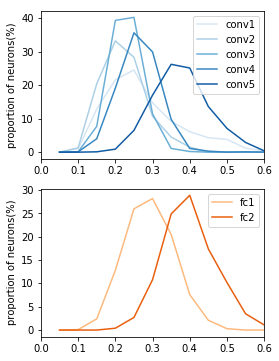

In [17]:
# plot Fig 1A or SS Fig 2A
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[4,6])
layer_legend = [layer.split('_')[0] for layer in layer_name]
# Conv
conv_colors = sns.color_palette('Blues', n_colors=len(layer_legend[:-2]))
[axes[0].plot(np.linspace(0, 1, bins+1)[1:], sp_bincount[:,i], c=conv_colors[i]) for i in range(len(layer_legend[:-2]))]
axes[0].set_xlim((0,0.6))
axes[0].legend(layer_legend[:-2])
axes[0].set_ylabel('proportion of neurons(%)')
# FC
fc_colors = sns.color_palette('Oranges', n_colors=2)
[axes[1].plot(np.linspace(0, 1, bins+1)[1:], sp_bincount[:,i+len(layer_legend[:-2])], c=fc_colors[i]) for i in range(2)]
axes[1].set_xlim((0,0.6))
axes[1].legend(layer_legend[-2:])
axes[1].set_ylabel('proportion of neurons(%)')

**Figure 1. Hierarchically sparse coding for object categories in DCNNs. (A)** Layer-wise PSI distribution for object categories in DCNNs. The sparseness was evaluated using the PSI for each object category from the ImageNet dataset (1,000 categories) in each layer separately. The distribution of PSI right-shifted along hierarchy in general. X axis: the degree of sparseness, with higher PSI indicating a higher degree of sparseness; Y axis: the proportion of categories with a corresponding PSI value. 

Text(0, 0.5, 'PSI')

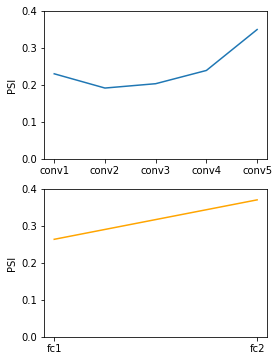

In [18]:
# plot Fig 1B or SS Fig 2B
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[4,6])
# Conv
axes[0].plot(layer_legend[:-2], sp_median[:-2], c='tab:blue')
axes[0].set_ylim((0,0.4))
axes[0].set_ylabel('PSI')
# FC
axes[1].plot(layer_legend[-2:], sp_median[-2:], c='orange')
axes[1].set_ylim((0,0.4))
axes[1].set_ylabel('PSI')

**Figure 1. Hierarchically sparse coding for object categories in DCNNs. (B)** Median of PSI for each layer. In general, the median of PSI increased along hierarchy in Conv and FC layers respectively. X axis: the name of layers along hierarchy; Y axis: the median of PSI. 

In [10]:
# stats trend test
sp_alllayer = np.asarray(sp).reshape(-1)
h_index = np.repeat(np.arange(len(sp))+1 , sp[0].shape)
tau = stats.kendalltau(h_index, sp_alllayer)
print(tau)

KendalltauResult(correlation=0.398335834980138, pvalue=0.0)


Text(0, 0.5, 'k in Weibull distribution')

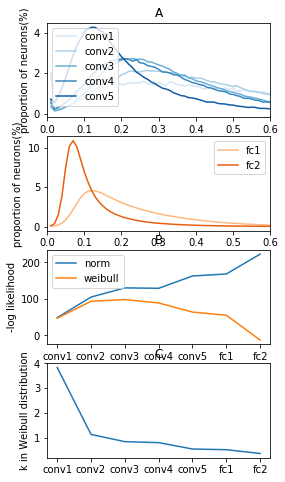

In [16]:
# plt SS Fig 1
# pdf fit
dist_model = ['norm','weibull']
log_lik = np.zeros((len(layer_name), len(dist_model)))
weib_paras = []
for i in range(len(layer_name)):
    data = pdf_bin[:, i] 
    row = 0
    # norm
    norm_para = stats.norm.fit(data)
    log_lik[i, row] = np.sum(stats.norm.logpdf(data, *norm_para)) 
    row += 1
    # weibull
    weib_para = stats.weibull_min.fit(data)
    log_lik[i, row] = np.sum(stats.weibull_min.logpdf(data, *weib_para)) 
    weib_paras.append(weib_para)
    row += 1
weib_k = np.asarray(weib_paras)[:,0]

# plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=[4,8])
# Conv
[axes[0].plot(np.arange(0,1,0.01)[1:], pdf_bin[:,i], c=conv_colors[i]) for i in range(len(layer_legend[:-2]))]
axes[0].set_xlim((0,0.6))
axes[0].legend(layer_legend[:-2])
axes[0].title.set_text('A')
axes[0].set_ylabel('proportion of neurons(%)')
# FC
[axes[1].plot(np.arange(0,1,0.01)[1:], pdf_bin[:,i+len(layer_legend[:-2])], c=fc_colors[i]) for i in range(2)]
axes[1].set_xlim((0,0.6))
axes[1].legend(layer_legend[-2:])
axes[1].set_ylabel('proportion of neurons(%)')
# comparison of fitting with Norm and Weibull
axes[2].plot(layer_legend, -1* log_lik)
axes[2].legend(dist_model)
axes[2].title.set_text('B')
axes[2].set_ylabel('-log likelihood')
# k in Weibull
axes[3].plot(layer_legend, weib_k)
axes[3].title.set_text('C')
axes[3].set_ylabel('k in Weibull distribution')

**Supplementary Figure 1. Longer-tail distribution of the population activation in higher layer in DCNNs. (A)** Layer-wise activation distribution of neuron population in DCNNs during object recognition. This analysis was performed on the ImageNet dataset. For each category, the activation distribution of all units in the same layer was first calculated with 100 bins between 0 to 1. Then the layer-wise activation distribution was obtained by averaging distributions over all categories. The activation distributions in higher layers showed heavier lower tails, indicating a larger number of silenced units. **(B)** Layer-wise negative log likelihood of fitting the population activation with Norm distribution and Weibull distribution. The probability density function of Norm distribution is symmetric, whereas that of Weibull distribution shows long-tail when k is smaller than 1. The population activation in higher layers were better fitted by Weibull distribution. **(C)** The estimated k in Weibull distribution. The estimated k became closer to 0 with the increasing layer, suggesting a longer-tail distribution in higher layer. That is, sparser population coding evolved along hierarchy.